> Importing needed libraries

In [35]:
import pandas as pd
import matplotlib as plt
import string
import nltk
import re
import unicodedata
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer

In [36]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nalindakulathunga/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [37]:
filenames = ['amazon_cells_labelled.txt', 'imdb_labelled.txt', 'yelp_train.txt']
with open('combined_reviews_ALL_YELP.txt', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            outfile.write(infile.read())
            
Combined_DF = pd.read_csv("combined_reviews_ALL_YELP.txt", sep='\t', names = ["Review", "Label"])
Combined_DF = Combined_DF.sample(frac=1).reset_index(drop=True)

In [38]:
print Combined_DF.head(10)

                                              Review  Label
0                               Doesn't hold charge.      0
1  Gave up trying to eat any of the crust (teeth ...      0
2  So there is no way for me to plug it in here i...      0
3  The seller is very understanding and patient, ...      1
4  Overall, I was very disappointed with the qual...      0
5  By the time the film ended, I not only dislike...      0
6             The directing seems too pretentious.        0
7  He was extremely rude and really, there are so...      0
8                                  THey are so cool!      1
9  Not only will it drain your player, but may al...      0


In [39]:
Combined_Df_RW = Combined_DF.drop('Label', axis=1)
Combined_Df_LB = Combined_DF["Label"]

In [40]:
print "\n___________ Reviews _____________\n"
print Combined_Df_RW.head(10)
print "\n___________ Labels _____________\n"
print Combined_Df_LB.head(10)


___________ Reviews _____________

                                              Review
0                               Doesn't hold charge.
1  Gave up trying to eat any of the crust (teeth ...
2  So there is no way for me to plug it in here i...
3  The seller is very understanding and patient, ...
4  Overall, I was very disappointed with the qual...
5  By the time the film ended, I not only dislike...
6             The directing seems too pretentious.  
7  He was extremely rude and really, there are so...
8                                  THey are so cool!
9  Not only will it drain your player, but may al...

___________ Labels _____________

0    0
1    0
2    0
3    1
4    0
5    0
6    0
7    0
8    1
9    0
Name: Label, dtype: int64


> Spliting data in to training and testing sets:

In [41]:
Yelp_test_DF = pd.read_csv("yelp_test.txt", sep='\t', names = ["Review", "Label"])
Yelp_test_Df_RW = Yelp_test_DF.drop('Label', axis=1)
Yelp_test_Df_LB = Yelp_test_DF["Label"]

X_train = Combined_Df_RW
X_test  = Yelp_test_Df_RW
y_train = Combined_Df_LB
y_test  = Yelp_test_Df_LB

#X_train, X_test, y_train, y_test = train_test_split(Combined_Df_RW, Combined_Df_LB, test_size=0.33, random_state=42)

In [42]:
print "\n___________ Training Reviews _____________\n"
print X_train.head()
print "\n___________ Training Labels _____________\n"
print y_train.head()


___________ Training Reviews _____________

                                              Review
0                               Doesn't hold charge.
1  Gave up trying to eat any of the crust (teeth ...
2  So there is no way for me to plug it in here i...
3  The seller is very understanding and patient, ...
4  Overall, I was very disappointed with the qual...

___________ Training Labels _____________

0    0
1    0
2    0
3    1
4    0
Name: Label, dtype: int64


In [43]:
print "\n___________ Testing Reviews _____________\n"
print X_test.head()
print "\n___________ Testing Labels _____________\n"
print y_test.head()


___________ Testing Reviews _____________

                                              Review
0  I also had to taste my Mom's multi-grain pumpk...
1            I'd rather eat airline food, seriously.
2      Cant say enough good things about this place.
3                       The ambiance was incredible.
4          The waitress and manager are so friendly.

___________ Testing Labels _____________

0    1
1    0
2    1
3    1
4    1
Name: Label, dtype: int64


In [44]:
print "\nTraining data length:"
print len(X_train)
print "\nTesting data length:"
print len(X_test)


Training data length:
2248

Testing data length:
500


> Naive Guesser: (assuming all labels to be positive)

In [45]:
Y_pred_all_Pos = []

for i in range(len(X_test)):
    Y_pred_all_Pos.append(1)

print "length of the naively assumed list:"
print len(Y_pred_all_Pos)


length of the naively assumed list:
500


In [46]:
print "Accuracy with Naive guesser:"
print np.mean(Y_pred_all_Pos == y_test)

Accuracy with Naive guesser:
0.438


In [47]:
from sklearn import metrics
print(metrics.classification_report(y_test, Y_pred_all_Pos, target_names="PN"))

             precision    recall  f1-score   support

          P       0.00      0.00      0.00       281
          N       0.44      1.00      0.61       219

avg / total       0.19      0.44      0.27       500



> Functions prepare words for lemmatizing

In [48]:
def strip_accents(text):
    """
    Remove accents from input String.
    """
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

def text_to_id(text):
    """
    Convert input text to id.
    """
    text = strip_accents(text.lower())
    text = re.sub('[ ]+', '_', text)
    text = re.sub('[^0-9a-zA-Z_-]', '', text)
    return text

> Pre-Processing

In [49]:
def PreProcess(InList = []):
    """
    This function gets an input list and remove punctuations, convers charactors to lower case and laso look for 
    any empty strings if available. Then it lemmatize the words. Returns a list with lemmatized sentences. 
    """
    X_List_nopunc = [''.join(c for c in s if c not in string.punctuation) for s in InList]
    X_List_nopunc_noempty = [s for s in X_List_nopunc if s]
    X_List_nopunc_noempty_nocaps = [x.lower() for x in X_List_nopunc_noempty]
    
    sent_list = []

    count = 0
    for item in range(len(InList)):
        count += 1
        word_string = ""
        for word in X_List_nopunc_noempty_nocaps[item][:].split(): 
            word_str = text_to_id(word)
            new_word = WordNetLemmatizer().lemmatize(word_str, 'v')
            word_string += str(new_word) + " "
        if word_string != "":
            sent_list.append(word_string)
    
    return sent_list

In [50]:
X_train_List = X_train["Review"].tolist()
X_train_List_cleaned = PreProcess(X_train_List)

X_test_List = X_test["Review"].tolist()
X_test_List_cleaned = PreProcess(X_test_List)

> Making a pipeline for the process with Multinomial Naive Bayes classifier:

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
text_clf_optimized = Pipeline([('vect_opt', CountVectorizer(stop_words='english')),
                     ('tfidf_opt', TfidfTransformer()),
                     ('clf_opt', MultinomialNB(alpha=0.6))])

In [52]:
text_clf_optimized.fit(X_train_List_cleaned, y_train) 

Pipeline(steps=[('vect_opt', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
 ...e,
         use_idf=True)), ('clf_opt', MultinomialNB(alpha=0.6, class_prior=None, fit_prior=True))])

In [53]:
predicted_opt = text_clf_optimized.predict(X_test_List_cleaned)
print "Accuracy (Trained on all and tested on Yelp):"
print np.mean(predicted_opt == y_test)

Accuracy (Trained on all and tested on Yelp):
0.772


In [54]:
print(metrics.classification_report(y_test, predicted_opt, target_names="PN"))

             precision    recall  f1-score   support

          P       0.88      0.69      0.77       281
          N       0.69      0.88      0.77       219

avg / total       0.79      0.77      0.77       500



> Confusion metrix plotting:

In [55]:
import itertools
import numpy as np
import matplotlib.pyplot as pltpy

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pltpy.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    pltpy.imshow(cm, interpolation='nearest', cmap=cmap)
    pltpy.title(title)
    pltpy.colorbar()
    tick_marks = np.arange(len(classes))
    pltpy.xticks(tick_marks, classes, rotation=45)
    pltpy.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pltpy.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pltpy.tight_layout()
    pltpy.ylabel('True label')
    pltpy.xlabel('Predicted label')

> Confusion matrix for MultinomialNB:

Confusion matrix, without normalization
[[194  87]
 [ 27 192]]


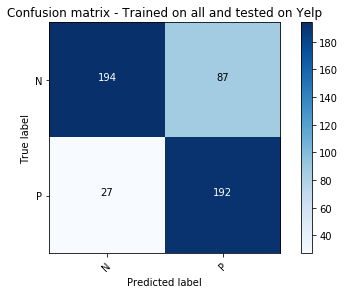

In [56]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cnf_matrix_NB = confusion_matrix(y_test, predicted_opt)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
pltpy.figure()
plot_confusion_matrix(cnf_matrix_NB, classes="NP",
                      title='Confusion matrix - Trained on all and tested on Yelp')
pltpy.show()